# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip

import pcshrink

# Data prep

Read in the human origins west eurasian data

In [2]:
%%time
data = pcshrink.UnpackedAncestryMap("/project/jnovembre/jhmarcus/ancient-sardinia/data/ref_genotypes/7-11-2018/lazaridis_2014/data_fil")

CPU times: user 8.12 s, sys: 2.54 s, total: 10.7 s
Wall time: 8.12 s


In [3]:
Y = data.Y
p, n = Y.shape
print(p, n)

594924 777


In [47]:
norm = pcshrink.Normalizer(Y, .02, "patterson")

In [48]:
Z = norm.Y
n_samp = Z.shape[1]
n_snp = Z.shape[0]

In [6]:
#idx = np.random.choice(list(range(n_samp)), size=200, replace=False)
#X = Y[:, idx] 
#norm = pcshrink.Normalizer(X, .02, "patterson")
#X = norm.Y
#n_snp, n_samp = X.shape

In [32]:
Y_ = Y[norm.snp_idx,:] - norm.mu
Y_[np.isnan(Y_)] = 0.0

In [33]:
Y_.shape

(426765, 777)

# PCA

In [9]:
def revise_svd(U, S, V, y, i):
    """
    """
    # number of samples
    n = V.shape[0]
    
    # table (1)
    a = -y.reshape(-1, 1)
    b = np.zeros((n, 1))
    b[i] = 1
    
    # rank k approximation
    k = S.shape[0]
    
    # equation (6)
    m = U.T @ a
    p = a - (U @ m)
    R_a = np.sqrt(p.T @ p)[0, 0]
    P = (1.0 / R_a) * p
    
    # equation (7)
    n = V.T @ b
    q = b - (V @ n)
    R_b = np.sqrt(q.T @ q)[0, 0]
    Q = (1.0 / R_b) * q
    
    # equation (8)
    K_0 = np.zeros((k+1, k+1))
    K_0[:k, :k] = S
        
    m_ = np.vstack([m, R_a]).reshape(-1, 1)
    n_ = np.vstack([n, R_b]).reshape(-1, 1)
    K = K_0 + (m_ @ n_.T)    
    
    # svd on K
#    tUp, Sp, tVpT = svds(K, k)
    tUp, Sp, tVpT = np.linalg.svd(K, full_matrices=True)
    #tUp = tUp[:, :k]
    #Sp = np.diag(Sp[:k])
    Sp = np.diag(Sp)
    #tVp = tVpT.T[:, :k]
    tVp = tVpT.T
    
    # equation (5)
    Up = np.hstack([U, P]) @ tUp
    Vp = np.hstack([V, Q]) @ tVp
    
    Up = Up[:, :k]
    Sp = Sp[:k, :k]
    Vp = Vp[:, :k]
    
    Up = orient_sign(Up, U)
    
    return((Up, Sp, Vp))

def ho_svd(Y, k, U_ref):
    
    U, S, VT = svds(Y, k)
    S = np.diag(S[::-1])
    U = orient_sign(U, U_ref)
    V = VT.T
    
    return((U, S, V))

def svd(Y, k):
    
    U, S, VT = svds(Y, k)

    # singular values
    S = np.diag(S[::-1])

    U, VT = svd_flip(U[:, ::-1], VT[::-1])

    V = VT.T
    
    return(U, S, V)

def orient_sign(U, U_ref):
    """
    """
    p, k = U.shape
    D = np.zeros((k, k))
    for i in range(k):
        D[i, i] = np.sign(np.corrcoef(U[:, i], U_ref[:, i])[0, 1])
    
    U = U @ D
    
    return(U)

In [49]:
ZtZ = (1.0 / n_snp) * Z.T @ Z

In [34]:
YtY = (1.0 / n_snp) * Y_.T @ Y_

In [50]:
_, Lamb, V = svd(ZtZ, n_samp-1)

0.55704635

In [61]:
(np.diag(Lamb)- 1)

array([ 6.52466440e+00,  2.42768478e+00,  1.65051603e+00,  9.98864055e-01,
        9.06675935e-01,  6.80661917e-01,  6.11660600e-01,  5.59756398e-01,
        5.17752528e-01,  4.76652861e-01,  4.43717480e-01,  4.07123566e-01,
        3.89065385e-01,  3.69274378e-01,  3.38564157e-01,  3.22162271e-01,
        3.12545180e-01,  3.07988048e-01,  3.03035498e-01,  2.94121504e-01,
        2.89903641e-01,  2.78513551e-01,  2.72388220e-01,  2.69136071e-01,
        2.64450431e-01,  2.63426900e-01,  2.60318279e-01,  2.57800817e-01,
        2.56065726e-01,  2.54555225e-01,  2.52726793e-01,  2.51295090e-01,
        2.48683333e-01,  2.44232416e-01,  2.43948698e-01,  2.40552306e-01,
        2.39599466e-01,  2.37235308e-01,  2.34569669e-01,  2.33741045e-01,
        2.32190490e-01,  2.29742169e-01,  2.27153897e-01,  2.26528049e-01,
        2.24284649e-01,  2.23736763e-01,  2.21917272e-01,  2.21514463e-01,
        2.19658494e-01,  2.18756795e-01,  2.14922428e-01,  2.13934898e-01,
        2.13370323e-01,  

Text(0,0.5,'eigen value')

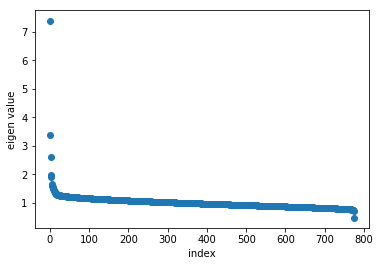

In [46]:
plt.scatter(np.arange(n_samp-1), np.diag(Lamb))
plt.xlabel("index")
plt.ylabel("eigen value")

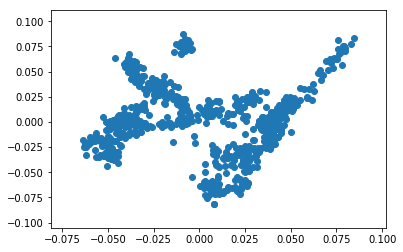

In [38]:
plt.scatter(V[:,0], V[:, 1])

In [9]:
%%time
for i in range(n_samp):
    print("i")
    idx = np.ones(n_samp, dtype="bool")
    idx[i] = False
    _, S, V = svd(ZtZ[idx, :][:, idx], 10)
    s = np.sqrt(np.diag(S))
    Sinv = 1. / np.sqrt(np.diag(S))
    U = Z[:, idx] @ V @ Sinv

i
i


KeyboardInterrupt: 

In [ ]:
%%time
k = 100
U, S, V = svd(Z, k)
F = U @ S
F = F / np.linalg.norm(F, axis=0, ord=2)
L = (F.T @ Z).T

In [ ]:
%%time
L_proj = np.empty((n_samp, k))
#L_ho = np.empty((n_samp, k))
for i in range(n_samp):
    
    if i % 25 == 0:
        print(i)
    
    Up, Sp, Vp = revise_svd(U, S, V, Z[:, i], i)
    Fp = Up @ Sp
    Fp = Fp / np.linalg.norm(Fp, axis=0, ord=2)
    L_proj[i, :] = (Fp.T @ Z[:, i]).T
    
    #c = np.ones(n_samp, dtype="bool")
    #c[i] = False
    #Uh, Sh, Vh = ho_svd(X[:, c], k, U)
    #Fh = Uh @ Sh
    #Fh = Fh / np.linalg.norm(Fh, axis=0, ord=2)
    #L_ho[i, :] = (Fh.T @ X[:, i]).T    

In [ ]:
l = 0
m = 1
plt.scatter(L[:, l], L[:, m])
plt.scatter(L_proj[:, l], L_proj[:, m], color="green")
#plt.scatter(L_ho[:, 0], L_ho[:, 1])


---

Run the svd actually holding out that point ... 

In [ ]:
j = 192
idx = np.zeros(n_samp, dtype="bool")
idx[j] = 1 
Zs = Z[:, ~idx]
Us, Ss, Vs = svd(Zs, k)
Fs = Us @ Ss
Fs = Fs / np.linalg.norm(Fs, axis=0, ord=2)
Ls = (Fs.T @ Z[:, j]).T

In [ ]:
plt.scatter(L[:,0], L[:,1])
plt.scatter(L[j, 0], L[j, 1], color="black")
plt.scatter(Ls[0], Ls[1], color="orange")